In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import stumpy
from sklearn.preprocessing import StandardScaler
from dao import DataLoading_dao
from matplotlib.patches import Rectangle
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA

c:\Users\ASUS\Desktop\MSc\Code Repositories\Anomaly Detection Project\KDD-Cup\data
c:\Users\ASUS\Desktop\MSc\Code Repositories\Anomaly Detection Project\KDD-Cup\data\001_UCR_Anomaly_35000.txt


<h2> Testing For Stationarity </h2>

In [47]:
#investigating whether all the datasets are stationary or not
num_datasets = len(os.listdir(DataLoading_dao.file_path))
adfuller_results = dict()
adfuller_results["Dataset"] = list()
adfuller_results["ADF Statistic"] = list()
adfuller_results["P value"] = list()
adfuller_results["Stationary"] = list()
adfuller_results["Lags used"] = list()
adfuller_results["1% Statistic"] = list()
adfuller_results["5% Statistic"] = list()
adfuller_results["10% Statistic"] = list()
for i in range(1,221,10):
    print(i)
    train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = i)
    data = np.concatenate((train,test)).reshape(-1,1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    result = adfuller(data,autolag='AIC')
    adfuller_results["Dataset"].append(i)
    adfuller_results["ADF Statistic"].append(result[0])
    adfuller_results["P value"].append(result[1])
    if result[1] < 0.05:
        adfuller_results["Stationary"].append(True)
    else: 
        adfuller_results["Stationary"].append(False)
    adfuller_results["Lags used"].append(result[2])
    adfuller_results["1% Statistic"].append(result[4]["1%"])
    adfuller_results["5% Statistic"].append(result[4]["5%"])
    adfuller_results["10% Statistic"].append(result[4]["10%"])

adfuller_results_df = pd.DataFrame(adfuller_results)
adfuller_results_df

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211


,Dataset,ADF Statistic,P value,Stationary,Lags used,1% Statistic,5% Statistic,10% Statistic
0,1,-31.135457,0.000000e+00,True,63,-3.430432,-2.861576,-2.566789
1,11,-30.311115,0.000000e+00,True,50,-3.430568,-2.861637,-2.566821
2,21,-12.417765,4.203032e-23,True,33,-3.430897,-2.861782,-2.566899
3,31,-11.920863,5.036201e-22,True,36,-3.431227,-2.861927,-2.566976
4,41,-18.391657,2.200207e-30,True,50,-3.430570,-2.861637,-2.566822
5,51,-21.371618,0.000000e+00,True,40,-3.430926,-2.861795,-2.566906
6,61,-27.037520,0.000000e+00,True,61,-3.430451,-2.861585,-2.566794
7,71,-35.969295,0.000000e+00,True,58,-3.430469,-2.861593,-2.566798
8,81,-45.853811,0.000000e+00,True,80,-3.430384,-2.861555,-2.566778
9,91,-43.166574,0.000000e+00,True,72,-3.430401,-2.861562,-2.566782


In [3]:
adfuller_results_df

,ADF Statistic,P value,Stationary,Lags used,1% Statistic,5% Statistic,10% Statistic
0,-31.135457,0.000000e+00,True,63,-3.430432,-2.861576,-2.566789
1,-30.311115,0.000000e+00,True,50,-3.430568,-2.861637,-2.566821
2,-12.417765,4.203032e-23,True,33,-3.430897,-2.861782,-2.566899
3,-11.920863,5.036201e-22,True,36,-3.431227,-2.861927,-2.566976
4,-18.391657,2.200207e-30,True,50,-3.430570,-2.861637,-2.566822
5,-21.371618,0.000000e+00,True,40,-3.430926,-2.861795,-2.566906
6,-27.037520,0.000000e+00,True,61,-3.430451,-2.861585,-2.566794
7,-35.969295,0.000000e+00,True,58,-3.430469,-2.861593,-2.566798
8,-45.853811,0.000000e+00,True,80,-3.430384,-2.861555,-2.566778
9,-43.166574,0.000000e+00,True,72,-3.430401,-2.861562,-2.566782


In [46]:
#investigating whether all the datasets are stationary or not
num_datasets = len(os.listdir(DataLoading_dao.file_path))
adfuller_results = dict()
adfuller_results["Dataset"] = list()
adfuller_results["ADF Statistic"] = list()
adfuller_results["P value"] = list()
adfuller_results["Stationary"] = list()
adfuller_results["Lags used"] = list()
adfuller_results["1% Statistic"] = list()
adfuller_results["5% Statistic"] = list()
adfuller_results["10% Statistic"] = list()
for i in [1,50,100,150,200,250]:
    print(i)
    train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = i)
    data = np.concatenate((train,test)).reshape(-1,1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    result = adfuller(data,autolag='AIC')
    adfuller_results["Dataset"].append(i)
    adfuller_results["ADF Statistic"].append(result[0])
    adfuller_results["P value"].append(result[1])
    if result[1] < 0.05:
        adfuller_results["Stationary"].append(True)
    else: 
        adfuller_results["Stationary"].append(False)
    adfuller_results["Lags used"].append(result[2])
    adfuller_results["1% Statistic"].append(result[4]["1%"])
    adfuller_results["5% Statistic"].append(result[4]["5%"])
    adfuller_results["10% Statistic"].append(result[4]["10%"])

adfuller_results_df = pd.DataFrame(adfuller_results)
adfuller_results_df

1
50
100
150
200
250


,Dataset,ADF Statistic,P value,Stationary,Lags used,1% Statistic,5% Statistic,10% Statistic
0,1,-31.135457,0.000000e+00,True,63,-3.430432,-2.861576,-2.566789
1,50,-21.861152,0.000000e+00,True,40,-3.430931,-2.861797,-2.566907
2,100,-16.418053,2.546028e-29,True,50,-3.430568,-2.861637,-2.566821
3,150,-15.744970,1.242888e-28,True,50,-3.430569,-2.861637,-2.566822
4,200,-41.116283,0.000000e+00,True,71,-3.430401,-2.861563,-2.566782
5,250,-9.456176,4.478928e-16,True,39,-3.430977,-2.861817,-2.566918


In [4]:
adfuller_results_df.to_csv("Stationary Results.csv")

Above representative datasets shows that the datasets are stationary as all the AD FUller tests have pvalues lower than 0.05.

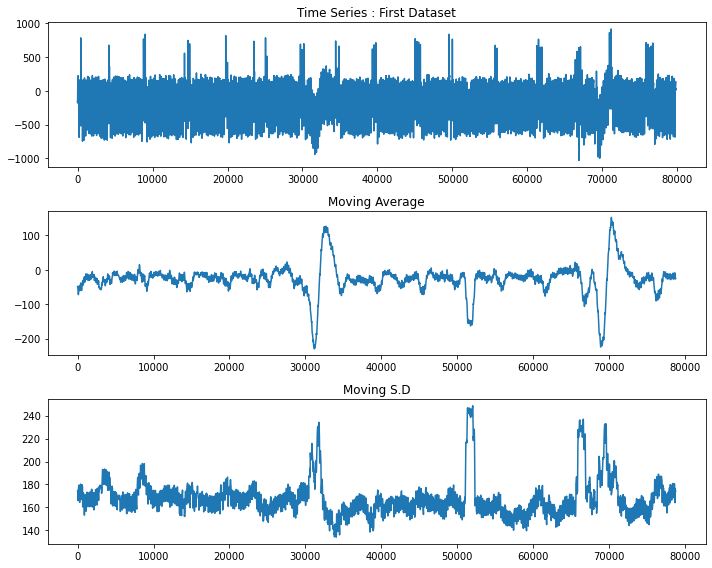

In [62]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 1)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 1000
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : First Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

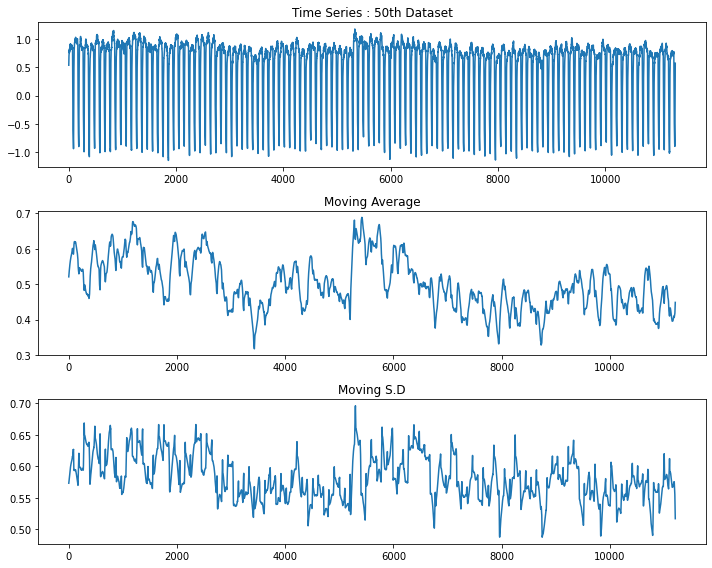

In [63]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 50)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 100
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : 50th Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

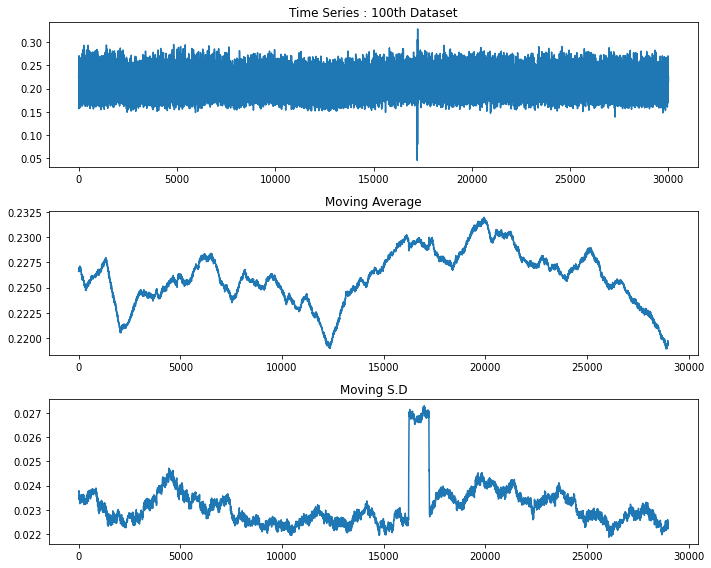

In [64]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 100)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 1000
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : 100th Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

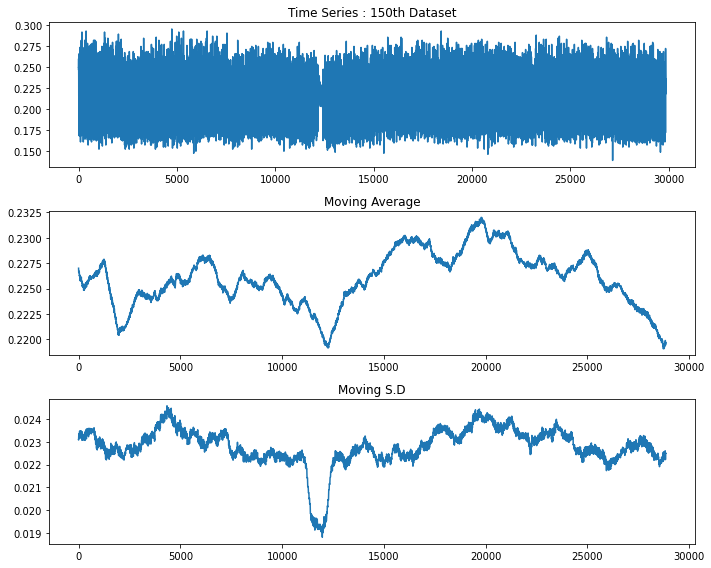

In [65]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 150)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 1000
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : 150th Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

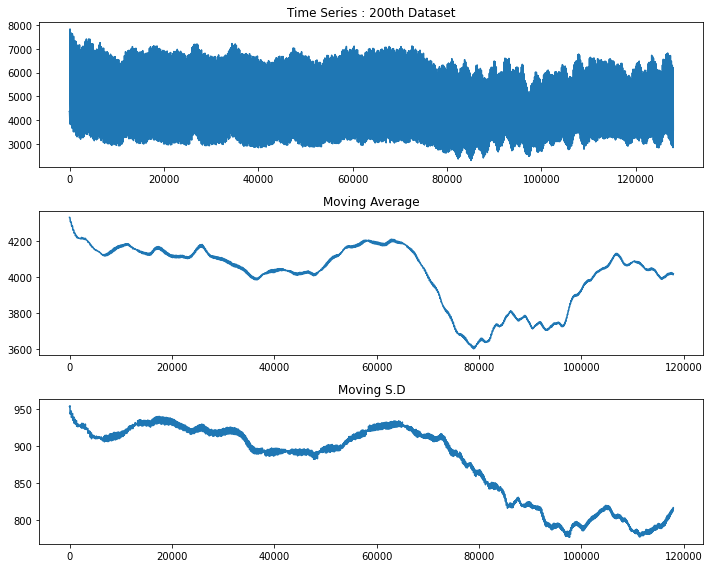

In [66]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 200)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 10000
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : 200th Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

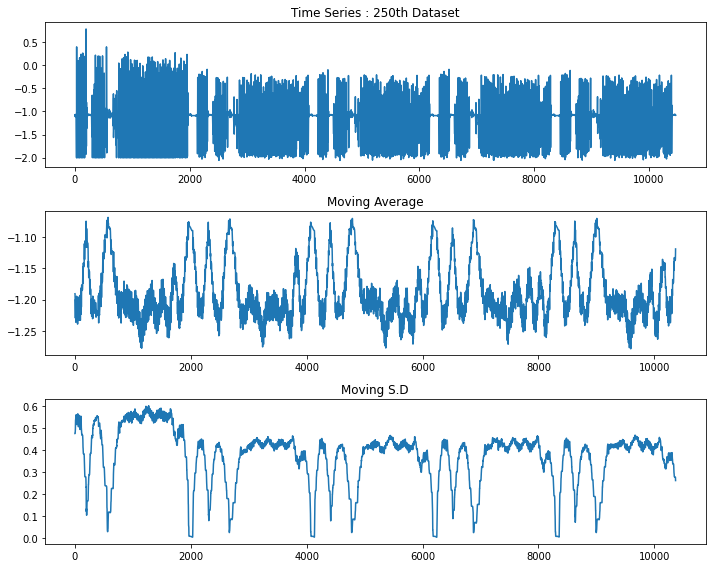

In [67]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 250)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 100
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - 100 + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[0].set_title('Time Series : 250th Dataset')
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[1].set_title('Moving Average')
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[2].set_title('Moving S.D')
plt.tight_layout()

Text(0.5, 1.0, '250th Dataset')

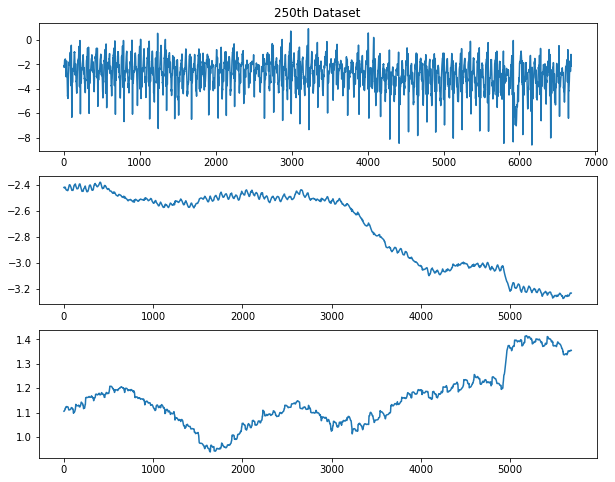

In [ ]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 54)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
data = np.concatenate((train,test))
fig,ax = plt.subplots(3,1,figsize = (10,8))
m = 1000
moving_average = list()
moving_std = list()
for i in range(0,data.shape[0] - m + 1):
    data_window = data[i:i+m]
    moving_average.append(np.mean(data_window))
    moving_std.append(np.std(data_window))

ax[0].plot(range(data.shape[0]),data)
ax[1].plot(range(data.shape[0] - m + 1),np.array(moving_average))
ax[2].plot(range(data.shape[0] - m + 1),np.array(moving_std))
ax[0].set_title('250th Dataset')

In [ ]:
list(range(1,251,49))

[1, 50, 99, 148, 197, 246]

In [3]:
train,test,test_data_start_pt = DataLoading_dao.split_data(file_path = DataLoading_dao.file_path,index = 1)
acf,ci = acf(train,alpha = 100, nlags = 150)

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
